# Load the `Jirachi.jl` package
- if you have installed the packages in your own `julia` env, then you can load `Jirachi.jl` by:
  - ```push!(LOAD_PATH, "../../lib_julia_external/Jirachi")```

- it may take a fews seconds to precompile the package for the first time we load it, be patient.

In [1]:
# load Jirachi.jl
push!(LOAD_PATH, "../../lib_julia_external/Jirachi")
using Jirachi

#load package for plotting.
using CairoMakie
using MakiePublication

# Load light curves

- we use `lightcurve` structure to save the light curves
- elements can be assessed via `lc.time`, `lc.flux`, `lc.err`.

In [17]:
i_lc = load_data("./data/i_4395.txt", [1, 2, 3]; band="i")
z_lc = load_data("./data/z_4395.txt", [1, 2, 3]; band="z")

# convert time to second, and start it from 0 second.
i_lc.time = round.(i_lc.time * 24 * 3600, digits=2)
i_lc.time = i_lc.time .- i_lc.time[1]
z_lc.time = round.(z_lc.time * 24 * 3600, digits=2)
z_lc.time = z_lc.time .- z_lc.time[1]

println(i_lc)
println(z_lc)

Loading lightcurve, band used: i-band
 

	 Time: 
		 min time: 0.0
		 max time: 23872.32
		 mean cadence: 105.16
		 median cadence: 103.68
 
	 Flux: 
		 mean flux: 0.6
		 median flux: 0.6
 
	 Error: 
		 mean error: 0.002149122807017544
		 median error: 0.002

Loading lightcurve, band used: z-band
 

	 Time: 
		 min time: 0.0
		 max time: 23880.96
		 mean cadence: 104.28
		 median cadence: 103.68
 
	 Flux: 
		 mean flux: 0.47
		 median flux: 0.47
 
	 Error: 
		 mean error: 0.0025826086956521744
		 median error: 0.003



## now get the light curves binned!
- you should input the bin size and where the bin start and end.

In [18]:
t_binsize = 103.68
lc_edges = bin_lc_edges(t_binsize, 0, 25000)

-51.84:103.68:25038.72

In [19]:
i_lc_bin = bin_light_curve(i_lc; lc_edges = lc_edges)
z_lc_bin = bin_light_curve(z_lc; lc_edges = lc_edges)

Loading lightcurve, band used: z-band

	 Time: 
		 min time: 0.0
		 max time: 24986.88
		 mean cadence: 103.68
		 median cadence: 103.68
	 Flux: 
		 mean flux: 0.47
		 median flux: 0.47
	 Error: 
		 mean error: 0.0025712396521364884
		 median error: 0.003


In [20]:
lc1_bin, lc2_bin = get_common_lc(i_lc_bin, z_lc_bin)
# lc1_bin.band = "i_bin"
# lc2_bin.band = "z_bin"

(Loading lightcurve, band used: i-band

	 Time: 
		 min time: 0.0
		 max time: 23846.4
		 mean cadence: 106.46
		 median cadence: 103.68
	 Flux: 
		 mean flux: 0.6
		 median flux: 0.6
	 Error: 
		 mean error: 0.002151111111111112
		 median error: 0.002
, Loading lightcurve, band used: z-band

	 Time: 
		 min time: 0.0
		 max time: 23846.4
		 mean cadence: 106.46
		 median cadence: 103.68
	 Flux: 
		 mean flux: 0.47
		 median flux: 0.47
	 Error: 
		 mean error: 0.002574411736387197
		 median error: 0.003
)

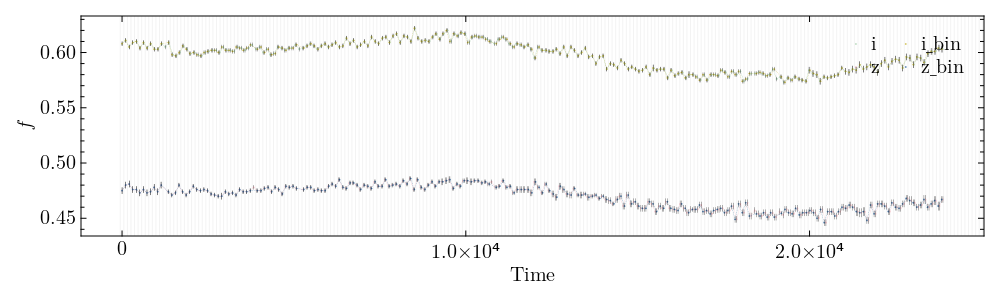

In [21]:
plotlc(i_lc, i_lc_bin, z_lc, z_lc_bin; label=[i_lc.band, i_lc.band * "_bin", z_lc.band, z_lc.band * "_bin"], lc_edges=lc_edges, save_fig_path="./fig/lc_check_i_z.svg", save_fig=true, hwratio=0.3)

In [22]:
# structure function 
sf_bin = 0.05
sf_bin_edges = 0:sf_bin:5 # in log space
mode = "both" # lc bootstrapped for structure function error
nsim = 1000 # lc bootstrapped for structure function error
lower_bounds = [0, 0, 0, 0.001]
upper_bounds = [10, 2e4, 2, 0.1]
p0 = [1, 1e3, 1, 0.005]

t_fit = 10 .^ range(log10(1), log10(6e4), step=0.1)

# color variation
cv_bin = 0.1
cv_bin_edges = 0:cv_bin:5 # in log space
nsigma = 3
erron=true

# save all run results.
fi_np::String="./data/run_i_z.h5"


"./data/run_i_z.h5"

In [23]:
fit_sf1 = fitsf_mcmc(lc1_bin; nsim=nsim, lb = lower_bounds , ub = upper_bounds, sf_bin_edges=sf_bin_edges, p0=p0, mode = mode)
fit_sf2 = fitsf_mcmc(lc2_bin; nsim=nsim, lb = lower_bounds, ub = upper_bounds, sf_bin_edges=sf_bin_edges, p0=p0, mode = mode)

binsf1, binsf2 = fit_sf1.binsf, fit_sf2.binsf

par_1, par_1_err = fit_sf1.param, fit_sf1.param_err
par_2, par_2_err = fit_sf2.param, fit_sf2.param_err


t_break_1 = find_t_break(binsf1)
t_break_2 = find_t_break(binsf2)

itp1 = find_t_min(binsf1, par_1; t_fit=t_fit)
itp2 = find_t_min(binsf2, par_2; t_fit=t_fit)

t_min_1, sf_min_1 = itp1.t_min, itp1.sf_min
t_min_2, sf_min_2 = itp2.t_min, itp2.sf_min

t_fit_1, sf_fit_1 = itp1.t_fit, itp1.sf_fit
t_fit_2, sf_fit_2 = itp2.t_fit, itp2.sf_fit


proper_time = [maximum([t_min_1, t_min_2]), minimum([t_break_1, t_break_2])]

 
[10.0, 13182.567385564074, 2.0, 0.1]
[1.0, 1000.0, 1.0, 0.005]
 
 
sigma: 0.52 +/- 0.03 
beta: 1.67 +/- 0.09 
tau: 9.21 +/- 1.38 
SF: 5.33 +/- 0.39 
 


 
[10.0, 13182.567385564074, 2.0, 0.1]
[1.0, 1000.0, 1.0, 0.005]
 
 
sigma: 0.69 +/- 0.03 
beta: 1.77 +/- 0.12 
tau: 13.18 +/- 2.85 
SF: 6.39 +/- 0.77 
 


2-element Vector{Float64}:
 3.4844129256093717
 4.12

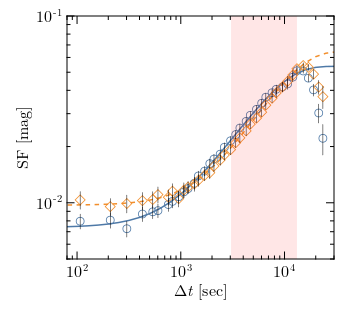

In [24]:

plotsf(binsf1, binsf2; fitsf1=[t_fit_1, sf_fit_1], fitsf2=[t_fit_2, sf_fit_2], proper_time = proper_time)

In [25]:
nsigma = nsigma
erron = erron

# cv in flux-Flux
cv_flux_res = color_variation(lc1_bin, lc2_bin, nsigma, erron, "flux")
cv_flux = cv_flux_res

bincv_flux = binned_color_variation(cv_flux, cv_bin_edges)

# cv in mag-mag
cv_mag_res = color_variation(lc1_bin, lc2_bin, nsigma, erron, "mag")
cv_mag = cv_mag_res

bincv_mag = binned_color_variation(cv_mag, cv_bin_edges)

binned_result([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95  …  4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95], [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05  …  0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  1.0063432989227807, 1.0446850849001021, 1.1512621944044665, 1.2836195587704153, NaN, NaN, NaN, NaN, NaN, NaN], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.004768467267551926, 0.006746507565954501, 0.009756967002478032, 0.021616733968476583, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float64[])

In [26]:
filter(row -> all(x -> !(x isa Number && isnan(x)), row), bincv_flux.y)

21-element Vector{Float64}:
 2.4444444444444446
 1.0
 0.7708333333333299
 0.6306818181818181
 0.8888888888888888
 0.7777777777777778
 0.6666666666666666
 0.6999999999999944
 0.6923076923076923
 0.6363636363636364
 ⋮
 0.6842105263157866
 0.7
 0.6909814323607406
 0.7272727272727256
 0.7564102564102549
 0.7916666666666644
 0.8214285714285694
 0.9047619047619021
 0.9999999999999969

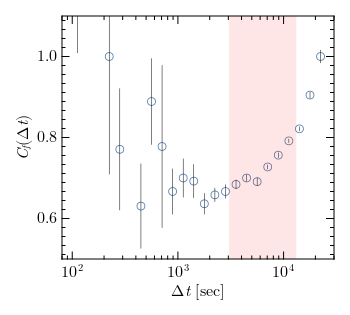

In [27]:
plotcv(bincv_flux; proper_time = proper_time)